<img src='https://i.imgur.com/fVakQcm.png'>


# 🔥 **2021 데이터 크리에이티브 캠프** 🔥 
<font size=5><b> 본선 3회차 매연 단속 프로그램 만들기<b></font>
<div align='right'>출제자:류 회 성<br>(hoesungryu@korea.ac.kr)</div>


<hr style="height:3px;border:none;color:#5F71F7;background-color:#5F71F7;" />

## 📌 문제  

최근 서울시는 저공해 조치를 하지 않은 `5등급 차량`의 `서울 중심부(옛 한양도성내부)` 진입을 `제한`하고 있다. 이에 진출입로 45곳에 설치된 카메라 119대를 통하여 단속을 하는 중이다. 이러한 단속을 `자동화하`기 위하여 **`자동차 차량의 종류`**를 **`예측(분류)`** 하는 프로그램을 만드시오.(데이터셋 별도제공)

<br>
<img src='https://pds.joins.com/news/component/htmlphoto_mmdata/202103/15/904c9f47-0b11-43c7-9f25-3c05c54abd88.jpg' width=50%>
<br>


## 📌 공통사항
- 모델은 딥러닝 모델로써 `torch`를 사용하게 제공됩니다. 
- 훈련데이터(Train Data): 15000장 이미지 *(각각의 클래스 3000 장의 이미지 $\times$ 5 클래스)*  
- 평가데이터(Test Data): 약 1000장 이미지 (각각의 클래스 20 장의 이미지 $\times$ 5 클래스)* 
- 목표: 1000장 이미지를 잘 분류하였는지 ROC-AUC로 평가하도록 한다. 


##  🖥 드라이브 연동 및 디렉토리 생성 

In [ ]:
# Mount
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os 
os.chdir('/content/gdrive/My Drive/Colab Notebooks/') # DataPath 설정 
current_path = os.getcwd() # 현재 폴더 위치

# 폴더 생성 
main_dir = os.path.join(current_path, '2021_data_creator_camp_1016')
data_path = os.path.join(main_dir,'data')
os.makedirs(main_dir, exist_ok=True) 
os.makedirs(data_path, exist_ok=True)

## 🖥 Download & Upload the Dataset

1. `Kaggle`접속(https://www.kaggle.com/t/fdbdadb8548240b38c004c34fc35b446) --> `Data` 클릭 --> 페이지 하단 다운받기 클릭 
2. 데이터셋 업로드

In [ ]:
# 데이터 경로 설정 
INIT_PATH = os.path.join(current_path, '2021_data_creator_camp_1016')
os.chdir(INIT_PATH)
print('정상적으로 디렉토리가 생성되었습니다. 하단 경로에 데이터를 넣어주세요.')
print('INIT_PATH:', INIT_PATH)

정상적으로 디렉토리가 생성되었습니다. 하단 경로에 데이터를 넣어주세요.
INIT_PATH: /content/gdrive/My Drive/Colab Notebooks/2021_data_creator_camp_1016


In [ ]:
# 압축 해제 --> 10 분 소요 
%%capture
if not os.path.exists(os.path.join(INIT_PATH,'dataset')):
    !tar -xvf dataset.tar.gz

## 🖥 압축확인

In [ ]:
from glob import glob

train = glob('./dataset/train/*.jpg')
train_json = glob('./dataset/train/*.json')
test = glob('./dataset/test/*.jpg')

if (len(train) == len(train_json)) and (len(test) == 995):
    print('|INFO| unzip succeed')
else:
    print('|INFO| unzip failed')


|INFO| unzip succeed


## 🖥 Visualize the dataset

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


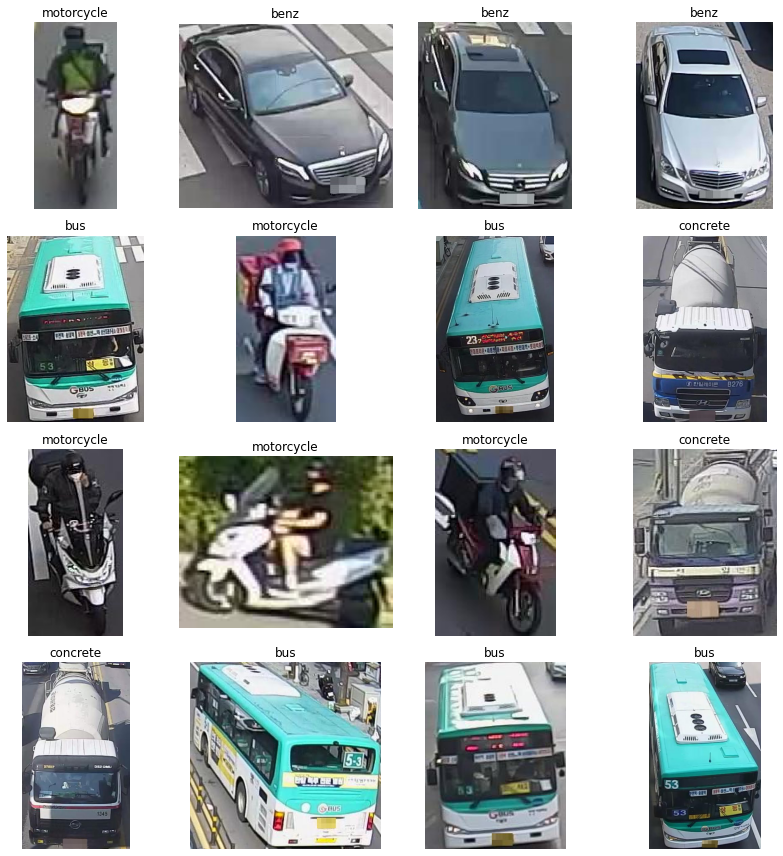

In [ ]:
import re 
import os 
from random import sample
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

regex = r'[A-Za-z]+'

eng_dict = {'motorcycle' : '오토바이',
            'concrete' : '레미콘',
            'bus' : '버스',
            'benz' : '벤츠',
            'suv':'SUV'
            }

plt.figure(figsize=(12,12))
for idx, (file_path) in enumerate(sample(train,16)):
    plt.subplot(4,4, idx+1)
    img = plt.imread(file_path)
    plt.imshow(img)
    
    
    basename = os.path.basename(file_path).split('.')[0]
    label = re.findall(regex,basename)[0]
    # plt.title(eng_dict[label])
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 🖥 Import 

In [ ]:
# import
import re 
import os
import PIL
import sys
import time
import random
import logging
import numpy as np
import pandas as pd
from datetime import datetime
from glob import glob
from tqdm import tqdm

# torch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision 
from torchvision import models
import torchvision.transforms as transforms

from torchsummary import summary

class AttributeDict(dict):
    def __init__(self):
        self.__dict__ = self
        
class ConfigTree:
    def __init__(self):
        self.DATASET = AttributeDict()
        self.SYSTEM = AttributeDict()
        self.TRAIN = AttributeDict()
        self.MODEL = AttributeDict()
        self.TEST = AttributeDict()

def print_overwrite(step, total_step, loss, acc, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write(f"Train Steps: {step}/{total_step} | Loss: {loss:.4f} | Acc: {acc*100.:.2f} %")   
    else:
        sys.stdout.write(f"Valid Steps: {step}/{total_step} | Loss: {loss:.4f} | Acc: {acc*100.:.2f} %")
    sys.stdout.flush()
    

def get_augmentation(size=224, use_flip=True, use_color_jitter=False, use_gray_scale=False, use_normalize=False):
    resize_crop = transforms.RandomResizedCrop(size=size)
    random_flip = transforms.RandomHorizontalFlip(p=0.5)
    color_jitter = transforms.RandomApply([
        transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
       
    ], p=0.8)
    gray_scale = transforms.RandomGrayscale(p=0.2)
    normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    to_tensor = transforms.ToTensor()
    
    transforms_array = np.array([resize_crop, random_flip, color_jitter, gray_scale, to_tensor, normalize])
    transforms_mask = np.array([True, use_flip, use_color_jitter, use_gray_scale, True, use_normalize])
    
    transform = transforms.Compose(transforms_array[transforms_mask])
    
    return transform


def encoding_name(filename):
    return os.path.basename(filename).split('.')[0]

def submmision(config,file_name,predictions):
    
    PATH = config.SYSTEM.SAVE_DIR
    TEAM_NAME = config.SYSTEM.TEAM_NAME.replace(" ","") # 공백제거
    
    # Make output directory
    SAVE_PATH = os.path.join(PATH, "output")
    os.makedirs(SAVE_PATH, exist_ok=True)

    today = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_name = os.path.join(SAVE_PATH, f'{TEAM_NAME}_{today}.csv')
    
    
    data = np.stack([np.array(file_name),np.array(predictions)],axis=1)
    
    
    # 결과 파일 저장 
    submmision = pd.DataFrame(data=data, columns=['encoded_name','label'])
    submmision['encoded_name'] = submmision['encoded_name'].apply(encoding_name)
    submmision.to_csv(csv_name,index=None)
    
    display(submmision)
 
    print(f'|INFO| DATE: {today}')
    print(f'|INFO| 제출 파일 저장 완료: {csv_name}')
    print('하단 주소에ㅔ 접속하여 캐글Leaderboard 에 업로드 해주세요.')
    print('https://www.kaggle.com/t/fdbdadb8548240b38c004c34fc35b446')
    

## Create dataset class

In [ ]:
import json
from PIL import Image
from pathlib import Path


class VehicleDataset(Dataset):
    def __init__(self, cfg, mode, transform):
        self.data_root = os.path.join(cfg.DATASET.ROOT, mode)
        self.mode = mode
        self.transform = transform
        self.images = sorted(glob(self.data_root + '/*.jpg'))
        if mode == 'train':
            self.annotations = sorted(glob(self.data_root + '/*.json'))

    def __len__(self):
        if self.mode == 'train':
            assert len(self.images) == len(
                self.annotations), "# of image files and # of json files do not match"
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image = Image.open(image)
        image = self.transform(image)

        if self.mode == 'train':
            annotation = self.annotations[index]
            label = self.get_gt(annotation)
            return image, label
        else:
            return image

    def get_gt(self, json_file):
        label_dict = {
            'motorcycle': 0,
            'concrete': 1,
            'bus': 2,
            'benz': 3,
            'suv': 4
        }

        json_file = Path(json_file)
        with open(json_file, 'r') as f:
            annotation = json.load(f)
        gt_class = label_dict[(annotation['label'])]

        return gt_class


<hr style="height:3px;border:none;color:#5F71F7;background-color:#5F71F7;" />

여기서 부터 시작하시면 되겠습니다. 

## 🛠 Configurations

In [ ]:
config = ConfigTree()
config.DATASET.ROOT = "./dataset/"  # data path
config.DATASET.NUM_CLASSES = 5  # 분류해야 하는 클래스 종류의 수

config.SEED = 2  # seed num

config.SYSTEM.GPU = 0  # GPU 번호
config.SYSTEM.PRINT_FREQ = 2  # 로그를 프린트하는 주기
config.SYSTEM.TEAM_NAME = 'RHS' # text.replace(" ","")
config.SYSTEM.SAVE_DIR = './save_csv' # 모델 파라미터가 저장되는 위치
config.SYSTEM.SAVE_CHECKPOINT = './checkpoint' # 모델 파라미터가 저장되는 위치

# hyperparameter of experiment
config.TRAIN.EPOCH = 10  # total training epoch
config.TRAIN.BATCH_SIZE = 256
config.TRAIN.BASE_LR = 0.01
config.TRAIN.WEIGHT_DECAY = 0.01
config.TRAIN.VALID_RATIO = 0.2
config.TRAIN.OPTIM = 'SGD'


# 사용할 augmentation
config.TRAIN.AUGMENTATION = {'size': 112, 'use_flip': True, 'use_color_jitter': False,
                             'use_gray_scale': False, 'use_normalize': True}  
config.TEST.AUGMENTATION = {'size': 224, 'use_normalize': True}

In [ ]:
# seed fix 
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# GPU allocation 
device = torch.device(f'cuda:{config.SYSTEM.GPU}' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
    torch.cuda.set_device(device)
    print ('Current cuda device ', torch.cuda.current_device()) # check
    with torch.cuda.device(f'cuda:{config.SYSTEM.GPU}'):
        torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Train

In [ ]:
transform = get_augmentation(**config.TRAIN.AUGMENTATION)

In [ ]:
dataset = VehicleDataset(config,'train',transform)

In [ ]:
len_valid_set = int(config.TRAIN.VALID_RATIO*len(dataset))
len_train_set = len(dataset) - len_valid_set
print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

The length of Train set is 14268
The length of Valid set is 3567


In [ ]:
train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=config.TRAIN.BATCH_SIZE,
                                           shuffle=True
                                           )

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=config.TRAIN.BATCH_SIZE,
                                          shuffle=True
                                           )

## Testing the shape of input data

In [ ]:
images, landmarks = next(iter(train_loader))
print(images.shape)

torch.Size([256, 3, 112, 112])


## Define the model

In [ ]:
model_arch='vgg11_bn'
init_weights = True
num_classes=5

model = models.__dict__[model_arch]()

in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features, num_classes)
model = model.to(device)

In [ ]:
summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1, 256,

In [ ]:
# update_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.__dict__[config.TRAIN.OPTIM]
optimizer = optimizer(model.parameters(), lr=config.TRAIN.BASE_LR, weight_decay=config.TRAIN.WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = config.TRAIN.EPOCH

loss_min = np.inf
start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    acc_train = 0
    acc_valid = 0
    running_acc = 0
    
    model.train()
    for step , (images, targets) in enumerate(train_loader):
    
        images, targets = images.to(device), targets.to(device)
        
        predictions = model(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, targets).to(torch.float32)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/(step+1)
        
        acc_train += predictions.argmax(-1).eq(targets).float().mean()
        running_acc = acc_train/(step+1)
        
        if step % config.SYSTEM.PRINT_FREQ == 0 :
            print_overwrite(step, len(train_loader), running_loss, running_acc, 'train')
        
    model.eval() 
    with torch.no_grad():
        for step , (images, targets) in enumerate(valid_loader):
            images, targets = images.to(device), targets.to(device)
            
            predictions = model(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, targets).to(torch.float32)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/(step+1)

            acc_valid += predictions.argmax(-1).eq(targets).float().mean()
            running_acc = acc_valid/(step+1)
            
            if step % config.SYSTEM.PRINT_FREQ == 0:
                print_overwrite(step, len(valid_loader), running_loss, running_acc, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    acc_train /= len(train_loader)
    acc_valid /= len(valid_loader)
    
    eta = time.time()-start_time
    epoch_eta = time.strftime('%H:%M:%S', time.gmtime(eta))
    print('\n\n'+'-'*90) 
    print('ETA: {} | Epoch: {}/{} | [Train] Loss: {:.4f}, Acc: {:.2f} % | [Valid] Loss: {:.4f}, Acc: {:.2f} %'
      .format(epoch_eta, epoch, num_epochs, loss_train,acc_train*100., loss_valid, acc_valid*100.))
    print('-'*90)
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(model.state_dict(), './vehicle_recognition.pth') 
        print("\nMinimum Validation Loss of {:.4f} & Acc of {:.2f} % at epoch {}/{}".format(loss_min,acc_valid*100., epoch, num_epochs))
        print('Model Saved\n')
        
print('Training Complete')
print("Total Elapsed Time : {}".format(time.strftime('%H:%M:%S', time.gmtime(time.time()-start_time))))

Valid Steps: 12/14 | Loss: 1.7558 | Acc: 22.81 %

------------------------------------------------------------------------------------------
ETA: 00:02:53 | Epoch: 1/10 | [Train] Loss: 251.2940, Acc: 21.94 % | [Valid] Loss: 1.7514, Acc: 22.52 %
------------------------------------------------------------------------------------------

Minimum Validation Loss of 1.7514 & Acc of 22.52 % at epoch 1/10
Model Saved

Valid Steps: 12/14 | Loss: 2.8348 | Acc: 23.74 %

------------------------------------------------------------------------------------------
ETA: 00:05:50 | Epoch: 2/10 | [Train] Loss: 1.7891, Acc: 23.12 % | [Valid] Loss: 2.8118, Acc: 23.90 %
------------------------------------------------------------------------------------------
Valid Steps: 12/14 | Loss: 1.6329 | Acc: 24.82 %

------------------------------------------------------------------------------------------
ETA: 00:08:43 | Epoch: 3/10 | [Train] Loss: 1.9183, Acc: 24.00 % | [Valid] Loss: 1.6266, Acc: 24.84 %
--------

## Submission 


### Predict on Test Images

In [ ]:
test_transform = get_augmentation(**config.TEST.AUGMENTATION)
test_dataset = VehicleDataset(config,'test', test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=4,
                                           )

In [ ]:
start_time = time.time()

predictions = []

with torch.no_grad():
    
    best_network = model
    best_network.load_state_dict(torch.load('./vehicle_recognition.pth')) 
    best_network.to(device)
    best_network.eval()

    print('Total number of test images: {}'.format(len(test_loader)))
    for batch_idx, images in tqdm(enumerate(test_loader)):
        images = images.to(device)
        
        outputs = best_network(images)
        pred = outputs.argmax(-1).to('cpu').tolist()
        predictions.extend(pred)

end_time = time.time()
print('Testing Complete')
print("Total Elapsed Time : {}".format(time.strftime('%H:%M:%S', time.gmtime(time.time()-start_time))))

In [ ]:
submmision(config, test_loader.dataset.images, predictions)